In [4]:
!pip install spotipy --upgrade
!pip install seaborn

## Extract Songs from Libraries

In [55]:
import os
from google.colab import userdata
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import json
import pandas as pd
import base64
from requests import post, get
import requests
from flask import Flask, request, url_for, session, redirect
import time
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

## Spotify Extraction

Create Spotify User Object

In [6]:
client_id = userdata.get('SPOTIFY_CLIENT_ID')
client_secret = userdata.get('SPOTIFY_CLIENT_SECRET')
client_credentials_mgmt = SpotifyClientCredentials(client_id= client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_mgmt)



Get Token From Client Info

In [75]:
def get_token():
    # concatenat id and secret
    auth_string = client_id + ":" + client_secret
    # encode auth_string
    auth_bytes = auth_string.encode("utf-8")
    # encode with base 64
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

    # url to send request to
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    # returns json string
    result = requests.post(url, headers=headers, data=data)
    # convert json to python dictionary
    json_result = json.loads(result.content)
    # get token from json
    token = json_result["access_token"]
    return token


def get_auth_header(token):
    return {"Authorization": "Bearer " + token}



def get_track_metadata(token, track_id):
    url = f"https://api.spotify.com/v1/tracks/{track_id}"
    headers = get_auth_header(token)

    result = get(url, headers=headers)

    # Check if the request was successful
    if result.status_code != 200:
        print(f"Error: Unable to get track metadata (Status code: {result.status_code})")
        return None

    try:
        json_result = json.loads(result.content)
        track_dict = {
            'track_id': track_id,
            'track_name': json_result.get('name', ''),
            'artist_name': json_result.get('album', {}).get('artists', [{}])[0].get('name', ''),
            'album_name': json_result.get('album', {}).get('name', ''),
            'release_date': json_result.get('album', {}).get('release_date', ''),
            'popularity': json_result.get('popularity', 0),
            'duration_ms': json_result.get('duration_ms', 0),
            'explicit': json_result.get('explicit', False),
            'artist_genres': json_result.get('album', {}).get('artists', [{}])[0].get('genres', []),
            'artist_popularity': json_result.get('album', {}).get('artists', [{}])[0].get('popularity', 0)

        }
        return pd.DataFrame([track_dict])
    except json.JSONDecodeError:
        print("Error: Unable to parse the response from Spotify")
        return None



# randomly sample songs from feats.csv
data = pd.read_csv('feats.csv')
data = data.sample(n=100)

track_ids = data['track_id'].tolist()
print("IDs: ", track_ids)

acousticdata = data[['track_id','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
print(acousticdata)


token = get_token()
meta_item = get_track_metadata(token, '02HhLYsY6X5D0qjxXvgWLY')
metadata = pd.DataFrame()
for track in track_ids:
    meta_item = get_track_metadata(token, track)
    #print("meta_item: ", meta_item)
    metadata = pd.concat([metadata, meta_item], ignore_index=True)
print(metadata.head)

IDs:  ['6ov7dWfxJsadTqkGZbmKOI', '6QvYmrqFKRSVrcVgvoA7Ar', '68ngc4vLwImhAeWHmXKcEI', '6SE4JAo7T8C7XkFka5bbga', '4mNj7IGiHfDKo6qtVqKLc2', '7mntHnF2frXuZwFAp8ouCB', '22zhfelopv8Xv6s26aoJof', '12niARgkwxGsklcEwh6GlG', '4gHnSNHs8RyVukKoWdS99f', '3dUXPkCP34x762v8cOJTRt', '6nvbYcbL79UQ5VFKE0aeeq', '3ROMQLV9N3HjrcqvV88dSP', '2ich9n3I8MHo1AkC26bpqK', '6Byuke1Ac5qWJHFgzu7byM', '5PJBDAjF0e14u3z7BMS72b', '1QSfgGcP3Rmdo2EdW1s4ya', '2RmGQmFyJetffds9FSRm3c', '2BTOY30m9duFKGrzQk8wWi', '4BTPwdNcGQK2GQxwvKkiZI', '769Fq73HiVK9qfOQKKvpLB', '4gb0u3m6CgWufipNiXx8ij', '1vpSPUyWEzmX8doyYdJ2TH', '6MCy7TQ6qOvEdayIkbC8kc', '4Y2W4zKa3q72ztbkA0r8Va', '0N8Xztr4pBHJ7V0moJWhbO', '0CDucx9lKxuCZplLXUz0iX', '1gj9poFl2mLKkguqWo5Y1i', '7aUuoq4oMfLxaLa5GVUDHi', '5KXEUYNvmPhOTsfxuWAXdp', '4dPVmeisPfQrLcjx0Wz1KW', '4ckTIXFjIHbZkK1HxisLFG', '44CBS46WolmxYXqHaa77An', '3TnFkFik1REVmx8V58n6Uu', '6pTZ8Oy1xGKGCE4saVScoy', '4hNUUHv2V4DkFTLtbhYGZX', '5sOHEiisdvTE72NZ2wFJvG', '7K6RK6aNVvcRZPBDoegoWO', '1955ZZJe1TzmSR0TomnNjI', '2bkJ

Sample Songs from Random Hits Playlist (https://open.spotify.com/playlist/5rRvWEETOsUk0tyhZ30cCw?si=65649706cbcf4a57)

Samples Songs from CSV and get metadata and acoustic data

Randomly Sampling Songs from CSV file

In [76]:
class SpotifyNeighborJoining:
    def __init__(self, data):
        self.data = data
        self.track_ids = data['track_id'].tolist()

        self.features = [col for col in data.columns if col != 'track_id']
        print("\nUsing features:", self.features)

        # Calculate feature weights
        self.feature_weights = self._calculate_variance_weights()

        print("\nFeature weights based on variance:")
        for feature, weight in sorted(self.feature_weights.items(), key=lambda x: x[1], reverse=True):
            print(f"{feature}: {weight:.4f}")

        # Normalize
        self.normalized_data = self._normalize_features()

        # Initialize clusters
        n_tracks = len(self.track_ids)
        self.clusters = {i: {'indices': [i], 'tracks': [self.track_ids[i]]}
                        for i in range(n_tracks)}

        self.distance_matrix = self._calculate_distance_matrix()

        self.clustering_history = []
        self.next_cluster_idx = n_tracks

    def _calculate_variance_weights(self):
        variances = self.data[self.features].var()
        log_variances = np.log1p(variances)

        min_val = log_variances.min()
        max_val = log_variances.max()
        weights = 0.5 + 0.5 * (log_variances - min_val) / (max_val - min_val)

        weights = weights / weights.sum()

        return dict(weights)

    def _normalize_features(self):
        feature_data = self.data[self.features].copy()
        normalized_features = []

        for feature in self.features:
            col = feature_data[feature]

            if col.dtype in ['int64', 'float64']:
                if col.std() != 0:
                    normalized_col = (col - col.mean()) / col.std()
                else:
                    normalized_col = col - col.mean()
                normalized_features.append(normalized_col.values.reshape(-1, 1))

            elif col.dtype == 'bool' or feature == 'explicit':
                normalized_col = col.astype(int)
                normalized_features.append(normalized_col.values.reshape(-1, 1))

            elif feature == 'date' or feature == 'release_date':
                dates = pd.to_datetime(col)
                days_since_min = (dates - dates.min()).dt.total_seconds() / (24*60*60)
                if days_since_min.std() != 0:
                    normalized_col = (days_since_min - days_since_min.mean()) / days_since_min.std()
                else:
                    normalized_col = days_since_min - days_since_min.mean()
                normalized_features.append(normalized_col.values.reshape(-1, 1))


        normalized_data = np.hstack(normalized_features)

        for i, feature in enumerate(self.features):
            normalized_data[:, i] *= np.sqrt(self.feature_weights[feature])

        return normalized_data



    def _calculate_distance_matrix(self):
        distances = pdist(self.normalized_data, metric='euclidean')
        return squareform(distances)

    def _calculate_q_matrix(self, distance_submatrix):
        n = len(distance_submatrix)
        if n < 2:
            return None

        row_sums = np.sum(distance_submatrix, axis=1)
        q_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(n):
                if i != j:
                    q_matrix[i,j] = (n-2) * distance_submatrix[i,j] - row_sums[i] - row_sums[j]

        return q_matrix

    def join_next_clusters(self):
        if len(self.clusters) < 2:
            return False

        current_indices = sorted(self.clusters.keys())
        n_current = len(current_indices)

        # Calculate current distances
        current_distances = np.zeros((n_current, n_current))
        for i, idx1 in enumerate(current_indices):
            for j, idx2 in enumerate(current_indices):
                orig_indices1 = self.clusters[idx1]['indices']
                orig_indices2 = self.clusters[idx2]['indices']
                distances = [self.distance_matrix[i1, i2]
                           for i1 in orig_indices1
                           for i2 in orig_indices2]
                current_distances[i,j] = np.mean(distances)

        # Calculate Q-matrix and find minimum
        q_matrix = self._calculate_q_matrix(current_distances)
        if q_matrix is None:
            return False

        mask = np.ones_like(q_matrix, dtype=bool)
        np.fill_diagonal(mask, False)
        min_i, min_j = np.unravel_index(np.argmin(q_matrix * mask), q_matrix.shape)

        # Get cluster indices and create new cluster
        cluster_i = current_indices[min_i]
        cluster_j = current_indices[min_j]

        new_cluster = {
            'indices': self.clusters[cluster_i]['indices'] + self.clusters[cluster_j]['indices'],
            'tracks': self.clusters[cluster_i]['tracks'] + self.clusters[cluster_j]['tracks']
        }

        # Store clustering step
        self.clustering_history.append({
            'joined_clusters': (self.clusters[cluster_i]['tracks'],
                              self.clusters[cluster_j]['tracks']),
            'new_cluster': self.next_cluster_idx,
            'distance': current_distances[min_i, min_j]
        })

        self.clusters[self.next_cluster_idx] = new_cluster
        del self.clusters[cluster_i]
        del self.clusters[cluster_j]

        self.next_cluster_idx += 1
        return True

    def perform_clustering(self):
        iteration = 0
        while len(self.clusters) > 1:
            success = self.join_next_clusters()
            if not success:
                print(f"Warning: Clustering stopped at iteration {iteration} with {len(self.clusters)} clusters remaining")
                break
            iteration += 1
            if iteration % 10 == 0:
                print(f"Completed {iteration} clustering steps. {len(self.clusters)} clusters remaining")

        if len(self.clusters) == 1:
            print(f"Clustering complete after {iteration} steps. All songs joined into one cluster.")

        return self.clustering_history

### Joining on Acoustic Data

In [77]:
nj = SpotifyNeighborJoining(acousticdata)
clustering_history = nj.perform_clustering()


Using features: ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

Feature weights based on variance:
tempo: 0.1534
loudness: 0.1188
key: 0.1071
mode: 0.0791
acousticness: 0.0781
instrumentalness: 0.0780
valence: 0.0775
energy: 0.0774
danceability: 0.0769
liveness: 0.0769
speechiness: 0.0767
Completed 10 clustering steps. 90 clusters remaining
Completed 20 clustering steps. 80 clusters remaining
Completed 30 clustering steps. 70 clusters remaining
Completed 40 clustering steps. 60 clusters remaining
Completed 50 clustering steps. 50 clusters remaining
Completed 60 clustering steps. 40 clusters remaining
Completed 70 clustering steps. 30 clusters remaining
Completed 80 clustering steps. 20 clusters remaining
Completed 90 clustering steps. 10 clusters remaining
Clustering complete after 99 steps. All songs joined into one cluster.


<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 24651 (\N{CJK UNIFIED IDEOGRAPH-604B}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 39764 (\N{CJK UNIFIED IDEOGRAPH-9B54}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 24859 (\N{CJK UNIFIED IDEOGRAPH-611B}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 33075 (\N{CJK UNIFIED IDEOGRAPH-8133}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 12434 (\N{HIRAGANA LETTER WO}) missing from current font.
  plt.tight_layout()
<ipython-input-

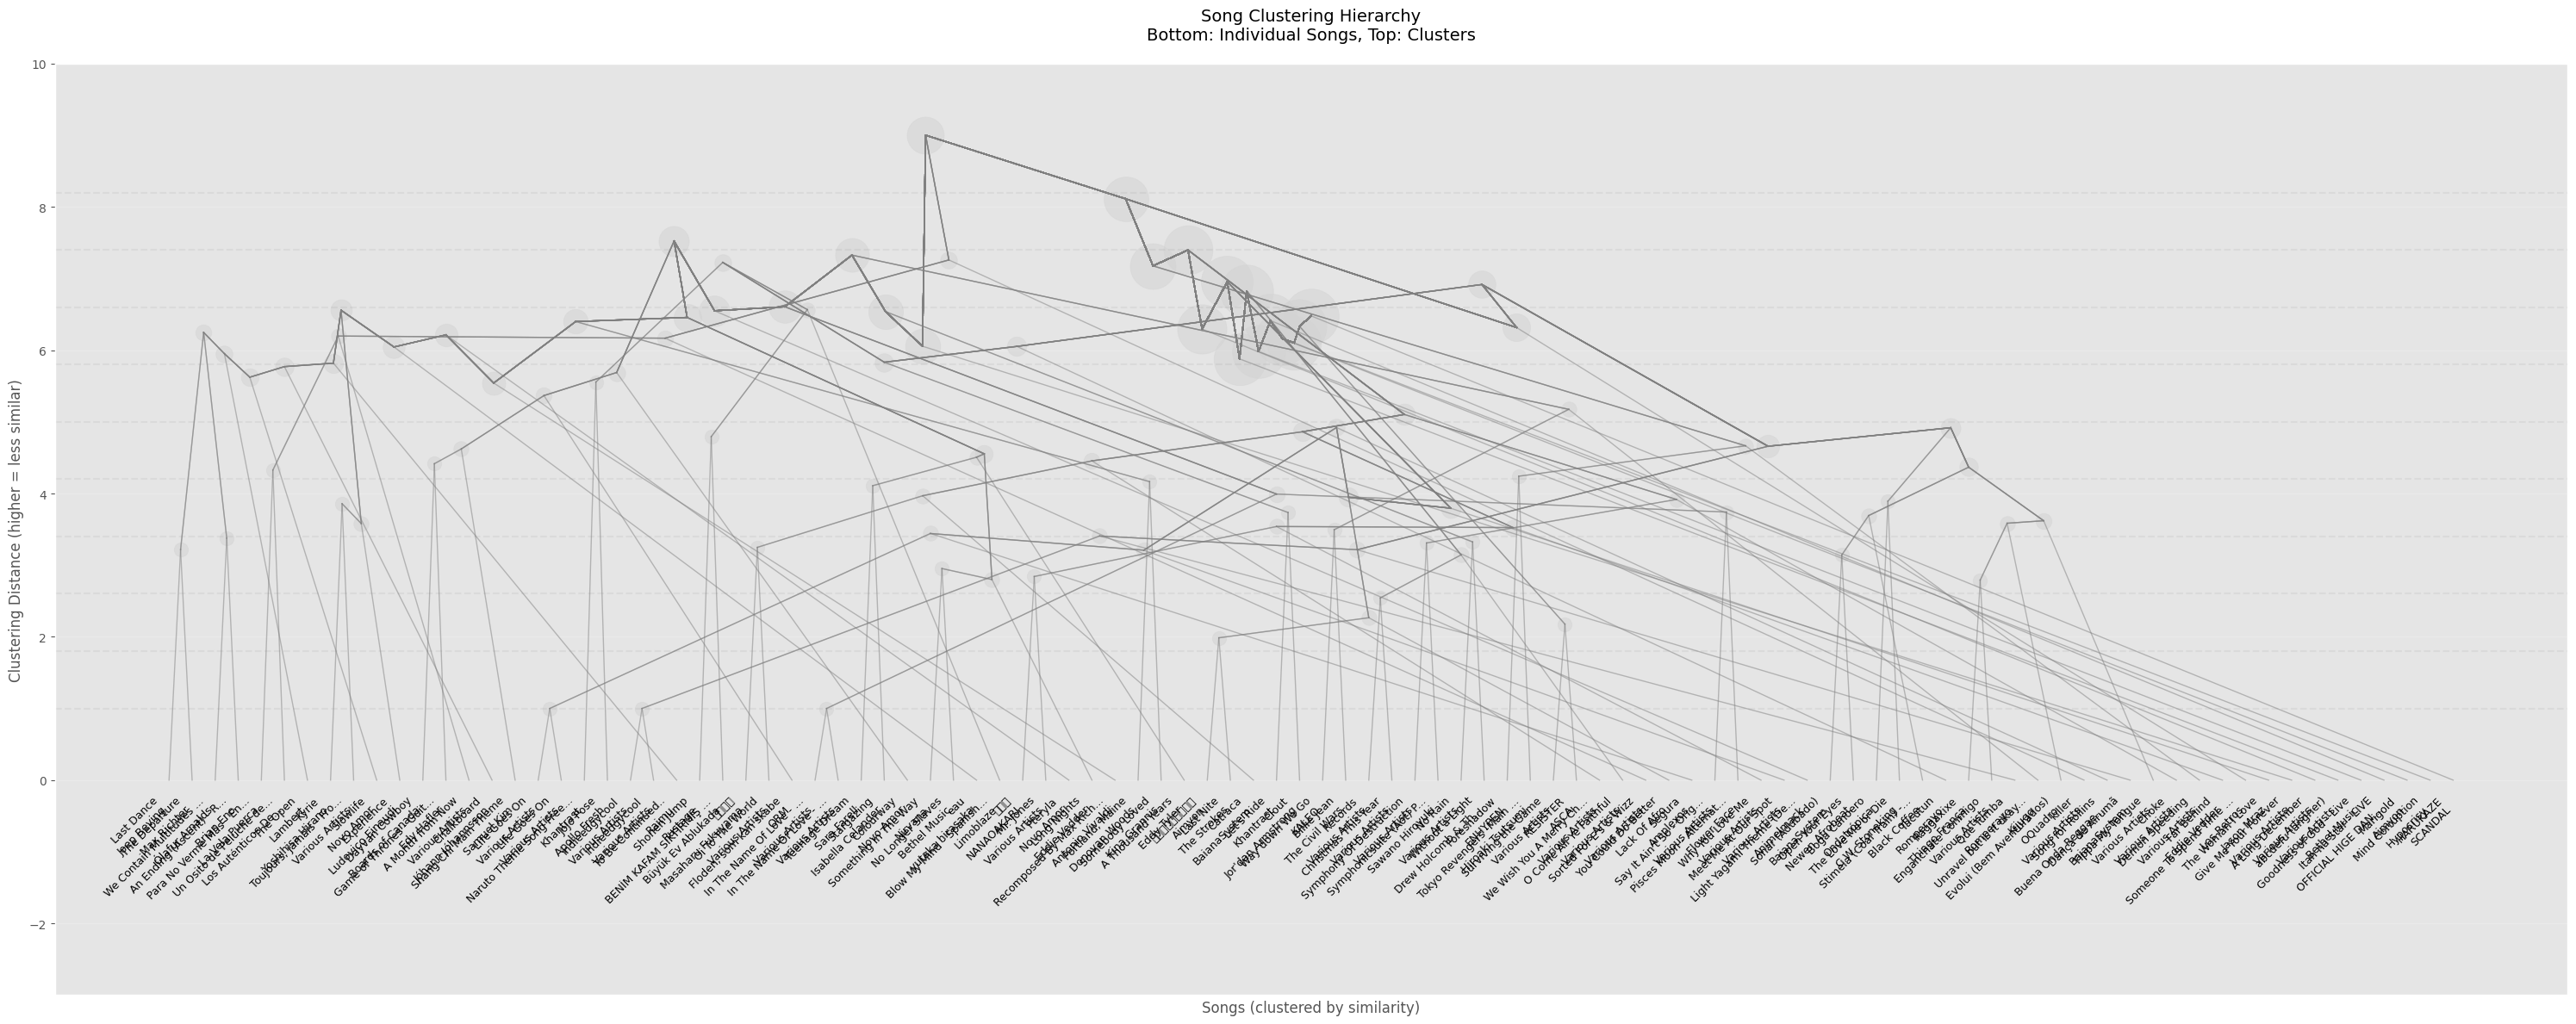


Clustering Statistics:
Number of songs: 100
Number of clustering steps: 99
Distance range: 0.00 to 1.79


In [78]:
class HierarchicalVisualizer:
    def __init__(self, clustering_history, metadata):
        self.clustering_history = clustering_history
        self.metadata = metadata

    def _get_ordered_tracks(self):
        ordered_tracks = []
        processed_tracks = set()

        for step in self.clustering_history:
            cluster1, cluster2 = step['joined_clusters']

            for track in cluster1 + cluster2:
                if track not in processed_tracks:
                    ordered_tracks.append(track)
                    processed_tracks.add(track)

        return ordered_tracks

    def visualize_hierarchy(self, figsize=(30, 12)):
        plt.figure(figsize=figsize)

        # Track positions of all nodes
        positions = {}

        # Get ordered tracks based on clustering
        leaf_tracks = self._get_ordered_tracks()

        # Position leaf nodes at bottom with wider spacing
        x_spacing = 1.5
        for i, track_id in enumerate(leaf_tracks):
            positions[track_id] = (i * x_spacing, 0)

            track_info = self.metadata[self.metadata['track_id'] == track_id].iloc[0]
            name = track_info['track_name']
            artist = track_info['artist_name']
            if len(name) > 25:
                name = name[:22] + "..."
            if len(artist) > 20:
                artist = artist[:17] + "..."

            plt.text(i * x_spacing, -0.2, f"{name}\n{artist}",
                    ha='right', va='top', rotation=45, fontsize=9)

        max_distance = max(step['distance'] for step in self.clustering_history)

        # Draw horizontal lines at distance intervals
        for d in np.arange(0, max_distance, max_distance/10):
            y = 1 + (d / max_distance) * 8
            plt.axhline(y=y, color='gray', alpha=0.1, linestyle='--')

        for i, step in enumerate(self.clustering_history):
            cluster1, cluster2 = step['joined_clusters']

            x_positions = []
            for track in cluster1 + cluster2:
                if track in positions:
                    x_positions.append(positions[track][0])
            x = np.mean(x_positions)

            y = 1 + (step['distance'] / max_distance) * 8

            cluster_id = f"cluster_{i}"
            positions[cluster_id] = (x, y)

            # Draw lines to children
            for track in cluster1 + cluster2:
                if track in positions:
                    child_x, child_y = positions[track]
                    plt.plot([x, child_x], [y, child_y], 'gray', alpha=0.5, linewidth=1)

            cluster_size = len(cluster1) + len(cluster2)
            plt.scatter(x, y, color='lightgray', s=100 + cluster_size*20, alpha=0.5)

            for track in cluster1 + cluster2:
                positions[track] = (x, y)

        plt.title('Song Clustering Hierarchy\nBottom: Individual Songs, Top: Clusters', pad=20, fontsize=14)
        plt.xlabel('Songs (clustered by similarity)', fontsize=12)
        plt.ylabel('Clustering Distance (higher = less similar)', fontsize=12)

        plt.gca().set_xticks([])
        plt.grid(True, alpha=0.2)

        plt.ylim(-3, 10)

        plt.tight_layout()
        plt.show()

        print("\nClustering Statistics:")
        print(f"Number of songs: {len(leaf_tracks)}")
        print(f"Number of clustering steps: {len(self.clustering_history)}")
        print(f"Distance range: {0:.2f} to {max_distance:.2f}")

visualizer = HierarchicalVisualizer(clustering_history, metadata)
visualizer.visualize_hierarchy()

<ipython-input-12-2ab015f2fcc7>:100: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from current font.
  plt.tight_layout()
<ipython-input-12-2ab015f2fcc7>:100: UserWarning: Glyph 38911 (\N{CJK UNIFIED IDEOGRAPH-97FF}) missing from current font.
  plt.tight_layout()
<ipython-input-12-2ab015f2fcc7>:100: UserWarning: Glyph 25955 (\N{CJK UNIFIED IDEOGRAPH-6563}) missing from current font.
  plt.tight_layout()
<ipython-input-12-2ab015f2fcc7>:100: UserWarning: Glyph 27468 (\N{CJK UNIFIED IDEOGRAPH-6B4C}) missing from current font.
  plt.tight_layout()
<ipython-input-12-2ab015f2fcc7>:100: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from current font.
  plt.tight_layout()
<ipython-input-12-2ab015f2fcc7>:100: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from current font.
  plt.tight_layout()
<ipython-input-12-2ab015f2fcc7>:100: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  plt.tight_layout()
<ipython-input-12-2ab015f

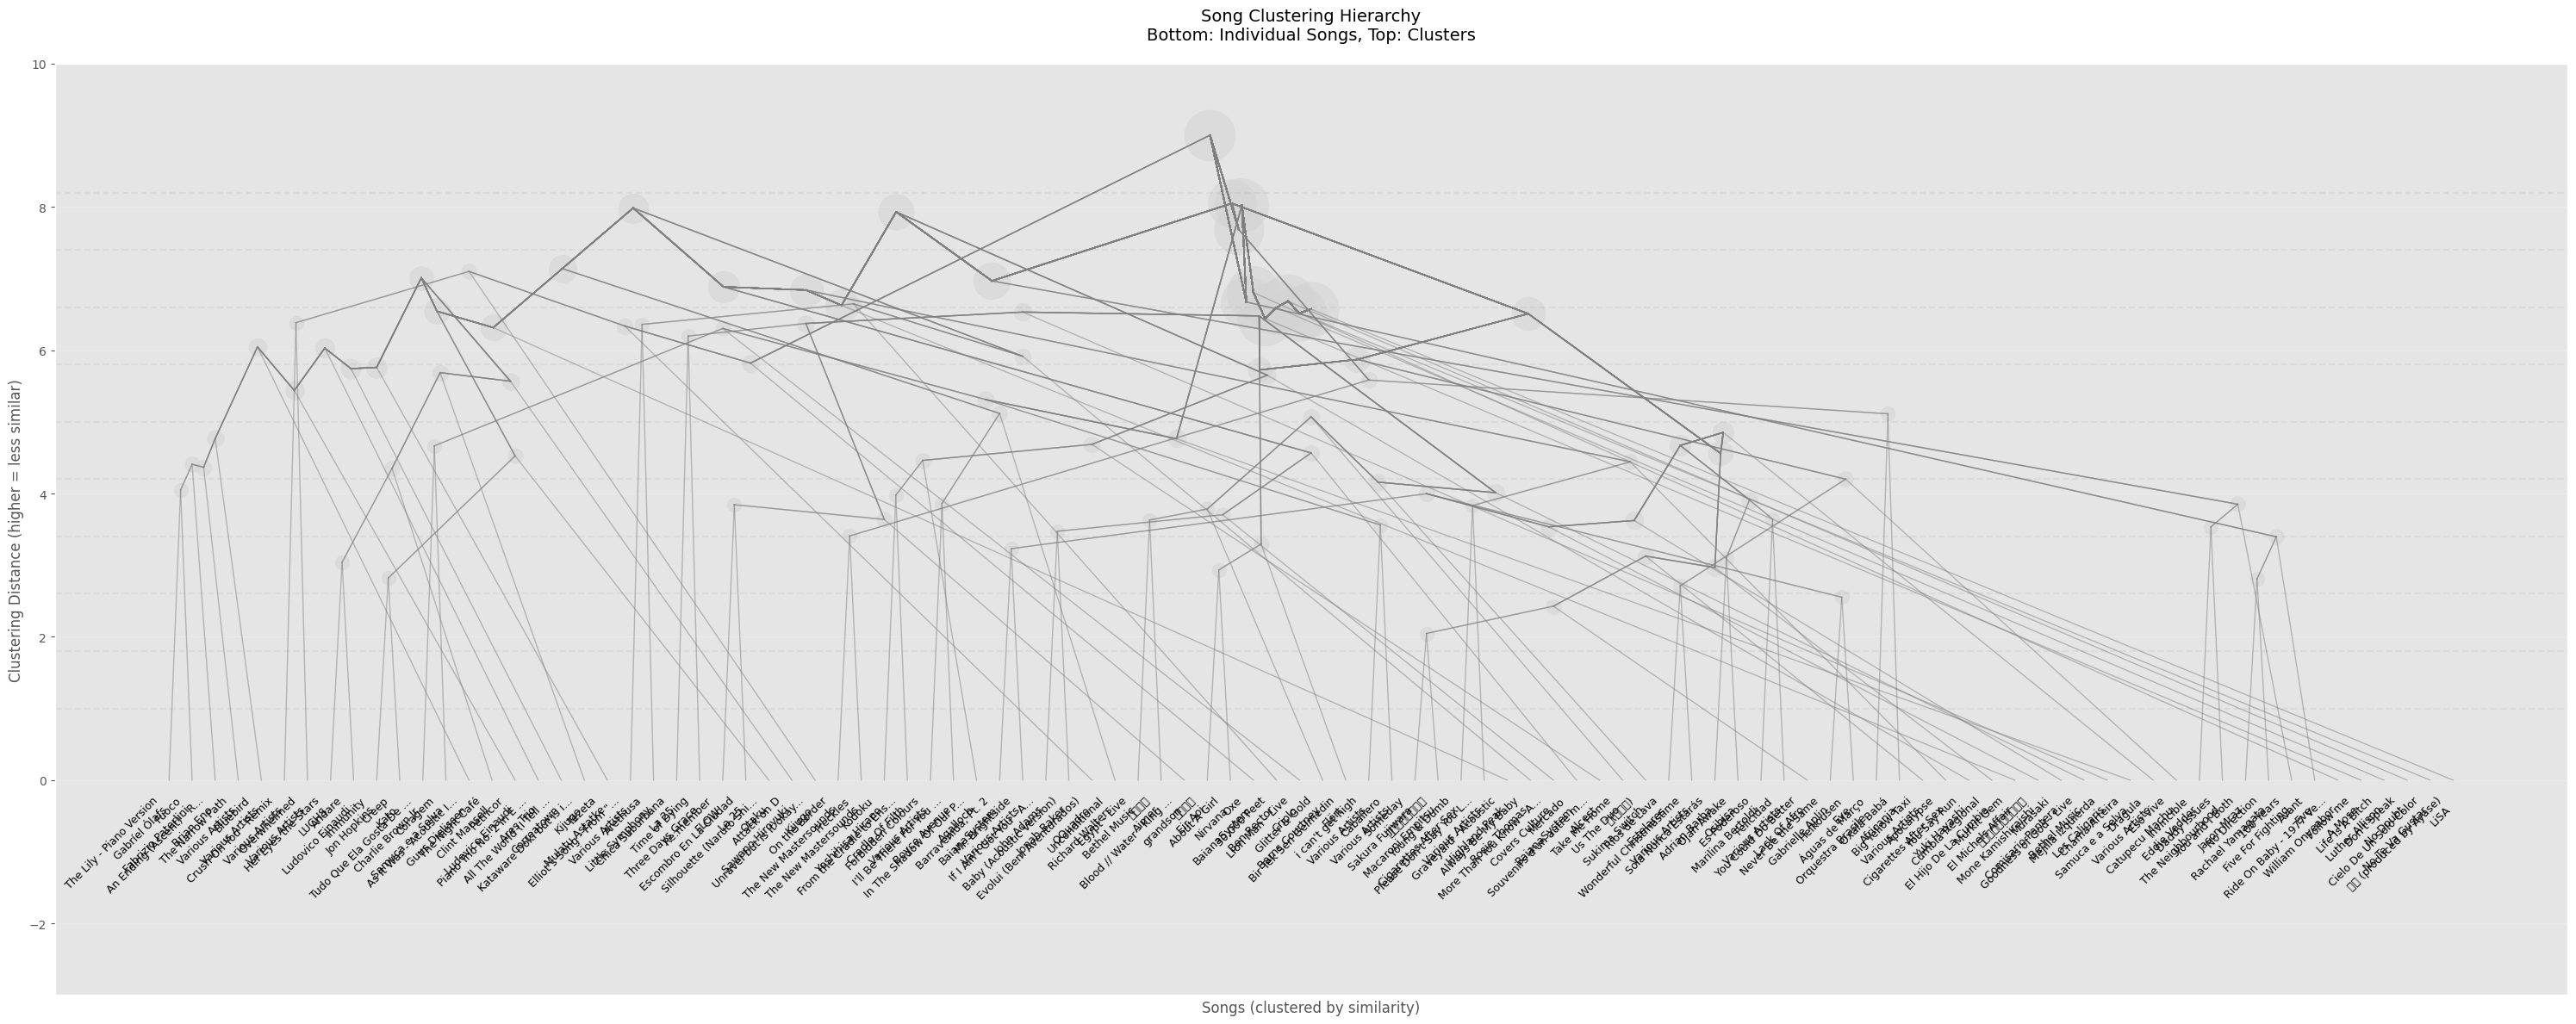


Clustering Statistics:
Number of songs: 100
Number of clustering steps: 99
Distance range: 0.00 to 1.69


In [19]:
visualizer = HierarchicalVisualizer(clustering_history, metadata)
visualizer.visualize_hierarchy()

Distance values across clustering steps:
Minimum (most similar): 0.000
Maximum (least similar): 1.893
Average: 0.637


In [88]:
target_song_index = metadata[(metadata['artist_name'] == "Nirvana")].index[0]
print(metadata.iloc[8])


track_id             4gHnSNHs8RyVukKoWdS99f
track_name             Something In The Way
artist_name                         Nirvana
album_name           Nevermind (Remastered)
release_date                     1991-09-26
popularity                               69
duration_ms                          232146
explicit                              False
artist_genres                            []
artist_popularity                         0
Name: 8, dtype: object


In [85]:
row_id = metadata.loc[8, 'track_id']
print(f"The ID of the row with index 87 is: {row_id}")




The ID of the row with index 87 is: 4gHnSNHs8RyVukKoWdS99f


In [96]:
def get_clusters_with_track_names(clustering_history, track_id, metadata):
    clusters_with_track = []
    all_songs = []
    def get_song_names(track_ids):
        names = []
        for tid in track_ids:
            row = metadata[metadata['track_id'] == tid]
            if not row.empty:
                track_name = row.iloc[0]['track_name']
                artist_name = row.iloc[0]['artist_name']
                names.append(f"{track_name} - {artist_name}")
            else:
                names.append(tid)
        return names

    for step in clustering_history:
        joined_clusters = step['joined_clusters']
        new_cluster_id = step['new_cluster']
        if track_id in joined_clusters[0] or track_id in joined_clusters[1]:
            clusters_with_track.append({
                'new_cluster_id': new_cluster_id,
                'joined_clusters': (
                    get_song_names(joined_clusters[0]),
                    get_song_names(joined_clusters[1])
                ),
                'distance': step['distance']
            })
    return clusters_with_track, all_songs

### Recommended Songs Via Acoustic Data


In [97]:
track_id_to_search = '4gHnSNHs8RyVukKoWdS99f'
clusters_with_names, all_songs = get_clusters_with_track_names(clustering_history, track_id_to_search, metadata)
print("Similar Songs: ", all_songs)
print(f"Clusters containing the song with track ID {track_id_to_search}:")
for cluster in clusters_with_names:
    print(f"New Cluster ID: {cluster['new_cluster_id']}")
    print(f"Joined Clusters:")
    print(f"  Cluster 1: {', '.join(cluster['joined_clusters'][0])}")
    print(f"  Cluster 2: {', '.join(cluster['joined_clusters'][1])}")
    print(f"Distance: {cluster['distance']}")
    print("-" * 40)

Similar Songs:  [['Something In The Way - Nirvana'], ['Long Nights - Eddie Vedder'], ['Long Nights - Eddie Vedder', 'Something In The Way - Nirvana', 'No Longer Slaves - Bethel Music'], ['Portland, Maine - Donovan Woods', 'Somebody Loved - Kina Grannis', 'Recomposed By Max Richter: Vivaldi, The Four Seasons: Spring 3 - 2012 - Antonio Vivaldi', 'Pteryla - Novo Amor', 'eau - yutaka hirasaka', 'Experience - Ludovico Einaudi', 'Kyrie - Yoshihisa Hirano', 'Toujours, jamais - From Les Demoiselles de Rochefort / The Young girls of Rochefort - Various Artists', 'To Be Continued.. - Raimu', 'Chalkboard - Jóhann Jóhannsson', 'Slowlife - Novo Amor', 'The Open - Lambert', 'Last Dance - Joep Beving', 'The Departure - Max Richter', 'We Contain Multitudes - from home - Ólafur Arnalds', 'An Ending (Ascent) - Remastered 2005 - Brian Eno'], ['Portland, Maine - Donovan Woods', 'Somebody Loved - Kina Grannis', 'Recomposed By Max Richter: Vivaldi, The Four Seasons: Spring 3 - 2012 - Antonio Vivaldi', 'Pter

### METADATA JOINING

In [98]:
metacopy = metadata.copy()
metacopy['explicit'] = metacopy['explicit'].astype(int)
columns_to_remove = ['track_name', 'artist_name', 'album_name', 'artist_genres']
metacopy = metacopy.drop(columns=columns_to_remove, errors='ignore')
metacopy['release_date'] = pd.to_datetime(metacopy['release_date'], errors='coerce', format='%Y-%m-%d').fillna(
    pd.to_datetime(metacopy['release_date'], format='%Y', errors='coerce'))
earliest_date = metacopy['release_date'].min()
metacopy['release_date'] = (metacopy['release_date'] - earliest_date).dt.total_seconds() / (24 * 60 * 60)

print(metacopy)



nj = SpotifyNeighborJoining(metacopy)
clustering_history = nj.perform_clustering()
print(metadata.head)

                  track_id  release_date  popularity  duration_ms  explicit  \
0   6ov7dWfxJsadTqkGZbmKOI       14254.0          39       189839         0   
1   6QvYmrqFKRSVrcVgvoA7Ar       14343.0           0       260808         0   
2   68ngc4vLwImhAeWHmXKcEI       12642.0          35       197195         0   
3   6SE4JAo7T8C7XkFka5bbga       13010.0          69       173953         0   
4   4mNj7IGiHfDKo6qtVqKLc2       14341.0          11       384106         0   
..                     ...           ...         ...          ...       ...   
95  1oEVFAAHzA8xPbPoaJB3bf       10541.0          41       315425         0   
96  3KG9I4JXpDwNQOsotE3uLh       11477.0          58        75849         0   
97  38UKRmA5IAaf1Vkx8ReHV0       14343.0           0       215217         0   
98  1wmOubz5LefeGM4KDAcsfz       14356.0           0       124653         0   
99  2WT4MG0M4R3RmkPUQj8Xct       13205.0          47       166853         0   

    artist_popularity  
0                   0  
1  

<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 24859 (\N{CJK UNIFIED IDEOGRAPH-611B}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 12434 (\N{HIRAGANA LETTER WO}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 20253 (\N{CJK UNIFIED IDEOGRAPH-4F1D}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 12360 (\N{HIRAGANA LETTER E}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 12383 (\N{HIRAGANA LETTER TA}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 12384 (\N{HIRAGANA LETTER DA}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: User

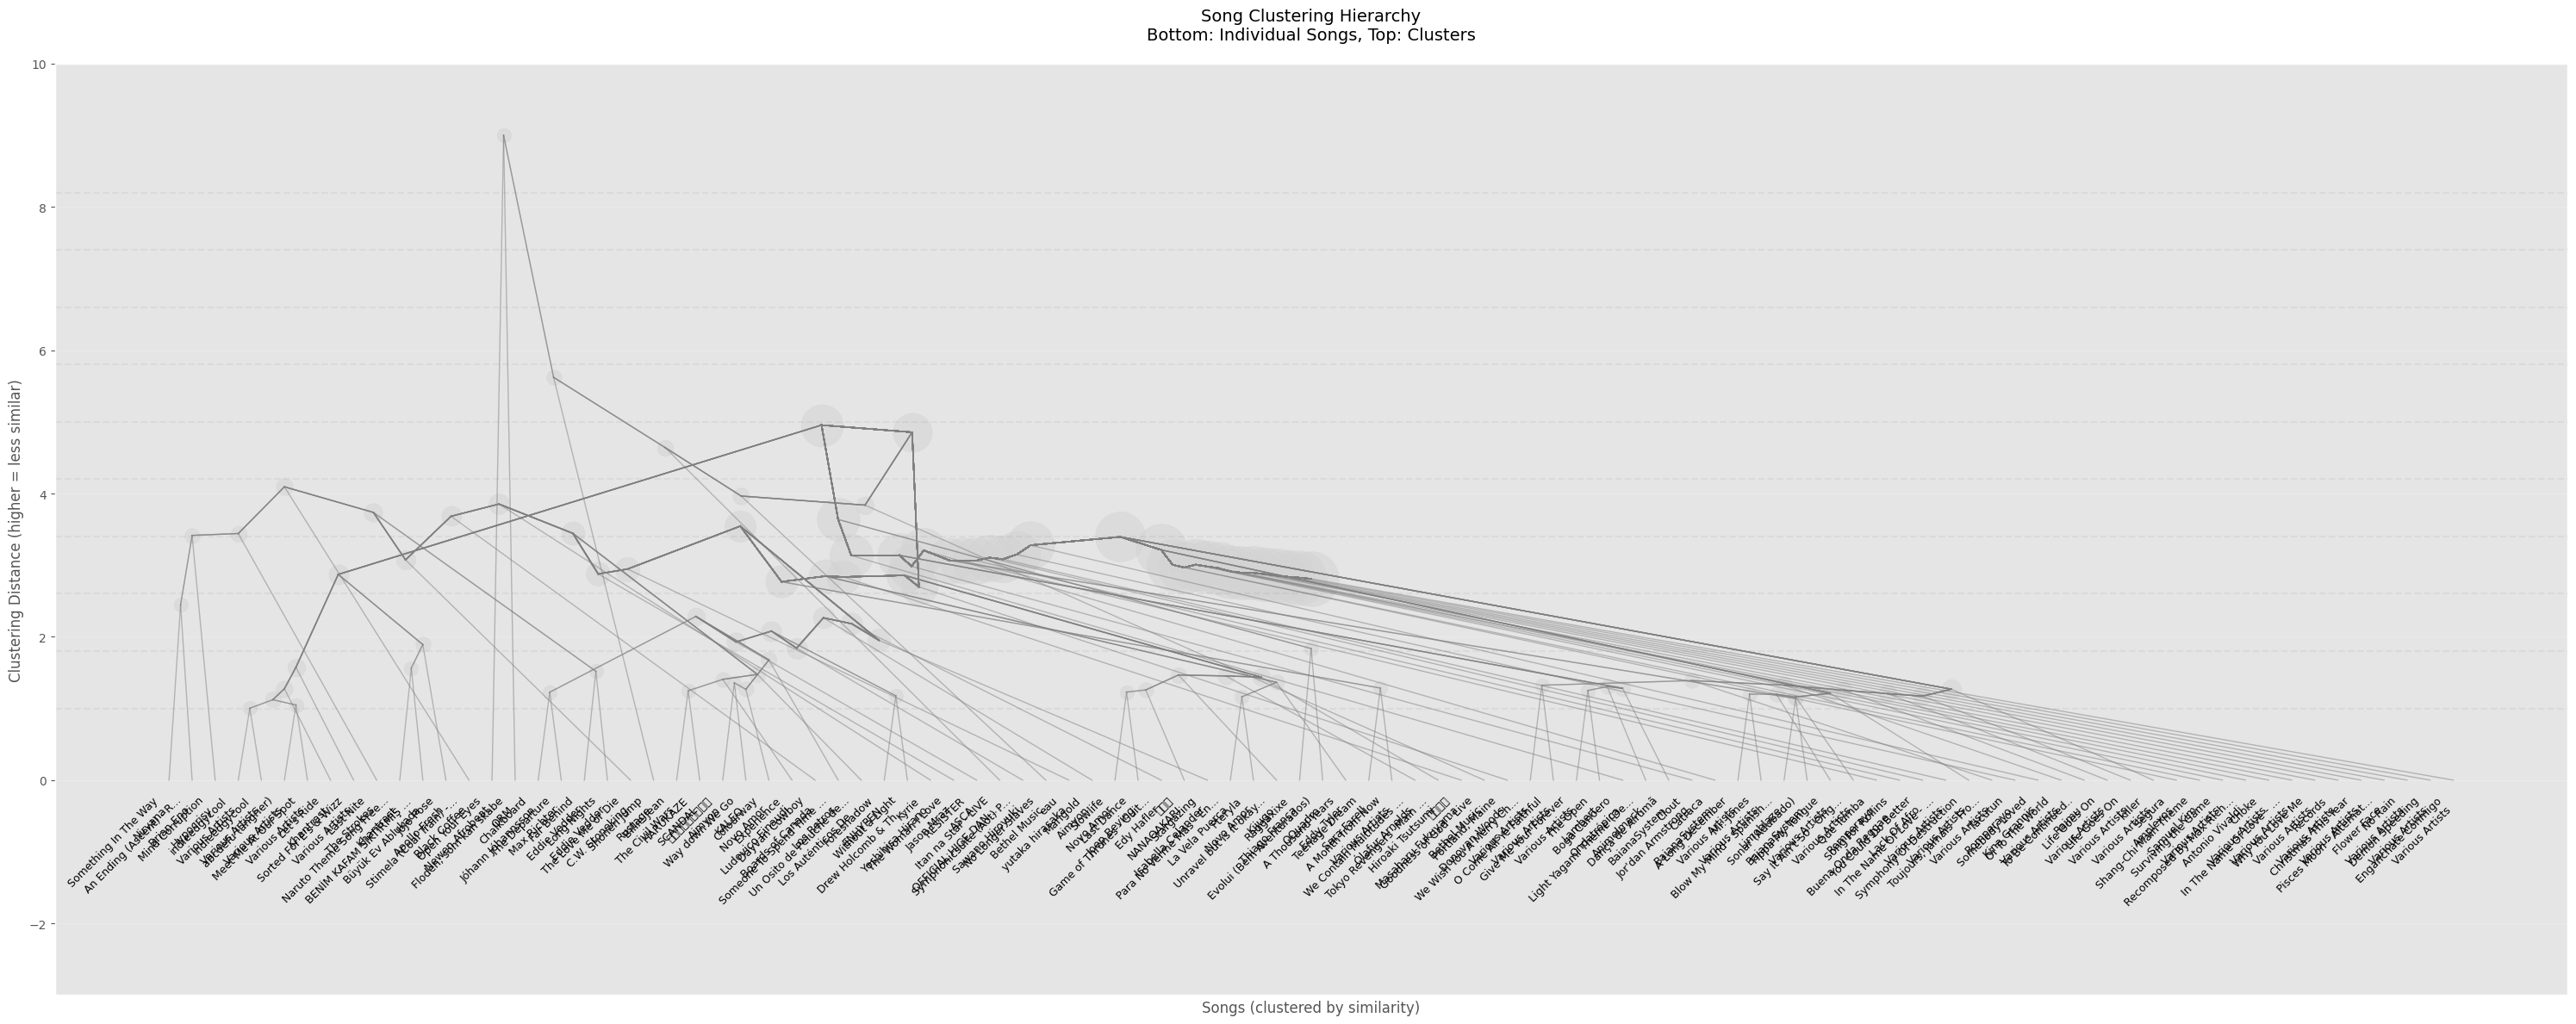


Clustering Statistics:
Number of songs: 100
Number of clustering steps: 99
Distance range: 0.00 to 3.64


In [99]:
visualizer = HierarchicalVisualizer(clustering_history, metadata)
visualizer.visualize_hierarchy()

In [100]:
distances = [step['distance'] for step in clustering_history]
print(f"Distance values across clustering steps:")
print(f"Minimum (most similar): {min(distances):.3f}")
print(f"Maximum (least similar): {max(distances):.3f}")
print(f"Average: {np.mean(distances):.3f}")

Distance values across clustering steps:
Minimum (most similar): 0.001
Maximum (least similar): 3.635
Average: 0.666


In [101]:
track_id_to_search = '4gHnSNHs8RyVukKoWdS99f'
clusters_with_names, all_songs = get_clusters_with_track_names(clustering_history, track_id_to_search, metadata)
print("Similar Songs: ", all_songs)
print(f"Clusters containing the song with track ID {track_id_to_search}:")
for cluster in clusters_with_names:
    print(f"New Cluster ID: {cluster['new_cluster_id']}")
    print(f"Joined Clusters:")
    print(f"  Cluster 1: {', '.join(cluster['joined_clusters'][0])}")
    print(f"  Cluster 2: {', '.join(cluster['joined_clusters'][1])}")
    print(f"Distance: {cluster['distance']}")
    print("-" * 40)

Similar Songs:  [['Something In The Way - Nirvana'], ['Mind Corruption - Hypocrisy'], ['Last Nite - The Strokes'], ['Stimela (Coal Train) - Black Coffee Remix - Black Coffee'], ['Stimela (Coal Train) - Black Coffee Remix - Black Coffee', 'Last Nite - The Strokes', 'Mind Corruption - Hypocrisy', 'Something In The Way - Nirvana', 'An Ending (Ascent) - Remastered 2005 - Brian Eno'], ['The Love Me or Die - C.W. Stoneking'], ['Dayvan Cowboy - Boards of Canada'], ['Kyrie - Yoshihisa Hirano'], ['Un Osito de Peluche de Taiwán (feat. Fernando Ruiz Díaz) - Vivo en el Palacio de los Deportes - Los Auténticos Decadentes', 'Experience - Ludovico Einaudi', 'Billie Jean - The Civil Wars', 'HARUKAZE - SCANDAL'], ['The Woman I Love - Jason Mraz'], ['eau - yutaka hirasaka'], ['eau - yutaka hirasaka', 'The Woman I Love - Jason Mraz', 'Un Osito de Peluche de Taiwán (feat. Fernando Ruiz Díaz) - Vivo en el Palacio de los Deportes - Los Auténticos Decadentes', 'Experience - Ludovico Einaudi', 'Billie Jean - 

### JOINING ON COMBINED

In [112]:
metacopy = metadata.copy()
metacopy['explicit'] = metacopy['explicit'].astype(int)
columns_to_remove = ['track_name', 'artist_name', 'album_name', 'artist_genres']
metacopy = metacopy.drop(columns=columns_to_remove, errors='ignore')
metacopy['release_date'] = pd.to_datetime(metacopy['release_date'], errors='coerce', format='%Y-%m-%d').fillna(
    pd.to_datetime(metacopy['release_date'], format='%Y', errors='coerce'))
earliest_date = metacopy['release_date'].min()
metacopy['release_date'] = (metacopy['release_date'] - earliest_date).dt.total_seconds() / (24 * 60 * 60)
combined_data = metacopy.merge(acousticdata, on='track_id')

# Select columns from metadata and acousticdata
columns_to_keep = ['duration_ms', 'release_date', 'tempo', 'loudness', 'key', 'mode']

bothdata = combined_data[['track_id'] + columns_to_keep]

print(bothdata.head())

                 track_id  duration_ms  release_date    tempo  loudness  key  \
0  6ov7dWfxJsadTqkGZbmKOI       189839       14254.0  156.099    -3.294  0.0   
1  6QvYmrqFKRSVrcVgvoA7Ar       260808       14343.0   88.418    -6.520  5.0   
2  68ngc4vLwImhAeWHmXKcEI       197195       12642.0  179.911   -15.478  6.0   
3  6SE4JAo7T8C7XkFka5bbga       173953       13010.0   89.570   -13.299  9.0   
4  4mNj7IGiHfDKo6qtVqKLc2       384106       14341.0   98.126    -5.965  8.0   

   mode  
0   1.0  
1   0.0  
2   1.0  
3   1.0  
4   1.0  


In [113]:

nj = SpotifyNeighborJoining(bothdata)
clustering_history = nj.perform_clustering()


Using features: ['duration_ms', 'release_date', 'tempo', 'loudness', 'key', 'mode']

Feature weights based on variance:
duration_ms: 0.2442
release_date: 0.2023
tempo: 0.1561
loudness: 0.1403
key: 0.1349
mode: 0.1221
Completed 10 clustering steps. 90 clusters remaining
Completed 20 clustering steps. 80 clusters remaining
Completed 30 clustering steps. 70 clusters remaining
Completed 40 clustering steps. 60 clusters remaining
Completed 50 clustering steps. 50 clusters remaining
Completed 60 clustering steps. 40 clusters remaining
Completed 70 clustering steps. 30 clusters remaining
Completed 80 clustering steps. 20 clusters remaining
Completed 90 clustering steps. 10 clusters remaining
Clustering complete after 99 steps. All songs joined into one cluster.


<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 24651 (\N{CJK UNIFIED IDEOGRAPH-604B}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 24859 (\N{CJK UNIFIED IDEOGRAPH-611B}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 33075 (\N{CJK UNIFIED IDEOGRAPH-8133}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 39764 (\N{CJK UNIFIED IDEOGRAPH-9B54}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from current font.
  plt.tight_layout()
<ipython-input-78-2ab015f2fcc7>:100: UserWarning: Glyph 12434 (\N{HIRAGANA LETTER WO}) missing from current font.
  plt.tight_layout()
<ipython-input-

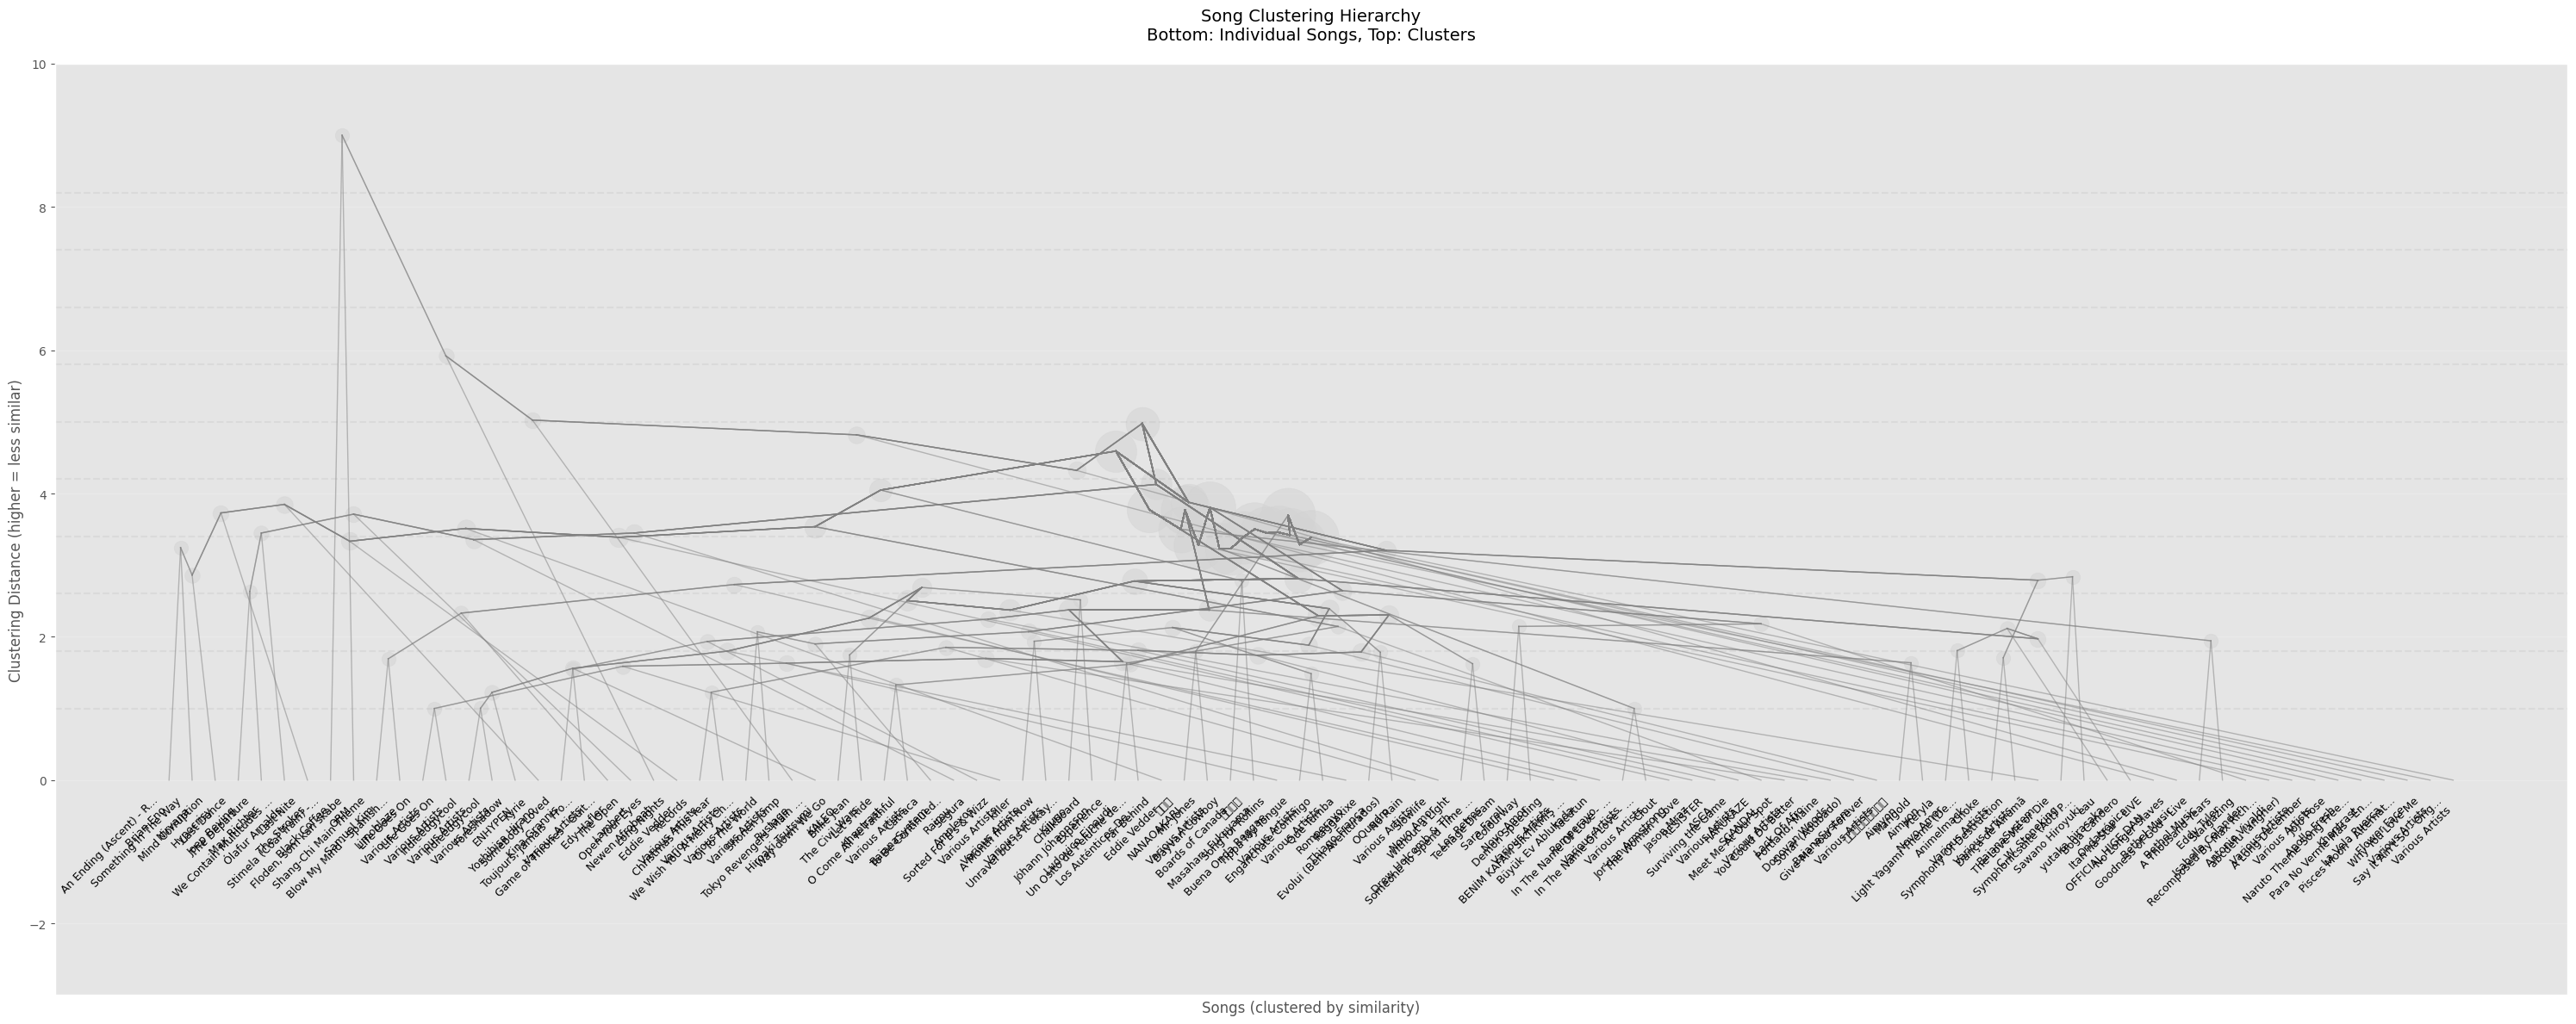


Clustering Statistics:
Number of songs: 100
Number of clustering steps: 99
Distance range: 0.00 to 3.71


In [114]:
visualizer = HierarchicalVisualizer(clustering_history, metadata)
visualizer.visualize_hierarchy()

In [115]:
track_id_to_search = '4gHnSNHs8RyVukKoWdS99f'
clusters_with_names, all_songs = get_clusters_with_track_names(clustering_history, track_id_to_search, metadata)
print("Similar Songs: ", all_songs)

print(f"Clusters containing the song with track ID {track_id_to_search}:")
for cluster in clusters_with_names:
    print(f"New Cluster ID: {cluster['new_cluster_id']}")
    print(f"Joined Clusters:")
    print(f"  Cluster 1: {', '.join(cluster['joined_clusters'][0])}")
    print(f"  Cluster 2: {', '.join(cluster['joined_clusters'][1])}")
    print(f"Distance: {cluster['distance']}")
    print("-" * 40)

Similar Songs:  [['An Ending (Ascent) - Remastered 2005 - Brian Eno'], ['Mind Corruption - Hypocrisy'], ['Last Nite - The Strokes'], ['Kyrie - Yoshihisa Hirano'], ['Long Nights - Eddie Vedder'], ['Far Behind - Eddie Vedder'], ['The Woman I Love - Jason Mraz'], ['The Woman I Love - Jason Mraz', 'Far Behind - Eddie Vedder', 'Long Nights - Eddie Vedder', 'Kyrie - Yoshihisa Hirano', 'Last Nite - The Strokes', 'Mind Corruption - Hypocrisy', 'An Ending (Ascent) - Remastered 2005 - Brian Eno', 'Something In The Way - Nirvana'], ['The Woman I Love - Jason Mraz', 'Far Behind - Eddie Vedder', 'Long Nights - Eddie Vedder', 'Kyrie - Yoshihisa Hirano', 'Last Nite - The Strokes', 'Mind Corruption - Hypocrisy', 'An Ending (Ascent) - Remastered 2005 - Brian Eno', 'Something In The Way - Nirvana', 'HARUKAZE - SCANDAL', 'Experience - Ludovico Einaudi', 'Un Osito de Peluche de Taiwán (feat. Fernando Ruiz Díaz) - Vivo en el Palacio de los Deportes - Los Auténticos Decadentes'], ['Demon Speeding - Various 